# Final Report : Plankton Recognition Challenge

> $ Group$ $ 3:  $ 
* $ ARRIAU$ $Emma$
* $ LUSCAN$ $ Pierre$
* $ MOSCHINI$ $ Irina$
* $ GUIGA $ $ Chloé $



This challenge aims at developing a model which accurately classify plankton images that has been collected since 2013. In total there are **39 'level2' categories** of planktons, which led us to a **multi-class classification problem**.

Two formats of data were provided : **images** of plankton and **features** manually engineered from these images. We decided to work both on the images (developping a Convolutional Neural Net) and on the features (developping Random Forest model) to compare these two approaches.

<br/>

This *presentation notebook* gives a concise summary of our findings. It will be structured in the following way : 

**I. Data Preparation** 

**II. Model Selection**

**III. Performance Evaluation** 

A *scratch notebook* is also available, where you will find our all code.

Remarks : 

- As said earlier, we decided to work both on the extracted features and on the images so the data preparation will be divided into 2 major parts which are data preparation for the features and data preparation for the images.
- All the plots, graph, images you will see in this _presentation notebook_ come from the _scratch notebook_ in order to avoid lines of code in this notebook which aims at going straight to the point.


In [0]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#I. Data preparation

This section aims at preparing **2 datasets** (one with features and one with images) that we will use for training the CNNs and the Random Forest. 

##I. a. Data preparation for the extracted features

###I. a. 1) Data preparation



We have 3 available datasets two of which contains extracted features of the planktons images : features_native.csv and features_skimage.csv. We found many relevant information while exploring them. Here are our main findings.


_features_native.csv_  


- There are **64 native features** (we don't count the objid)  which correspond to various characteristics of the samples such as the **_area_** which is the surface area of the object in square pixels, **_mean_** which is the average grey value within the object, **_width_** and **_height_** which contains the width and height of the smallest rectangle enclosing the object, etc. 
- We can notice that there is **only numerical** features. 

_features_skimage.csv_ 

- Concerning the skimage features, they were obtained by processing the native features with the scikit-image toolbox (more precisely the skimage.measure.regionprops function) which resulted in **65 features** (again we don't count the objid).
- For example, amongst the features computed with regionpros function we can find several **_weighted_moments_normalized_** which are normalized moments (translation and scale invariant) of intensity image up and **_moments_hu** which are Hu moments (translation, scale and rotation invariant), etc.
- As well as the native features, that there is **only numerical** features. 

_meta.csv_

This file is important because it contains the **index of images** and their corresponding **level2 labels**. 

Our findings enabled us to take the decision of **merging these 3 datasets** in order to have both the information contained in the native and in the skimage. We know that there may be a redundancy of information this is why we will try a Principal Components Analysis **(PCA)** to reduce the number of features we will use to train our model. 

Remark : both native and skimage datasets contains an _area_ feature, we will keep only one of them. Indeed, they respectively represent the area of the object and the ROI which is really similar so even if the two columns does not have the same values, they are really close and keeping the two features makes little sense.

### I. a. 2) Data visualization

In this part, we will focus on the **statistics** of the dataset such as the _level2_ distribution.

In [0]:
meta_pd = pd.read_csv('/content/drive/My Drive/Plankton Recognition Challenge/Data/meta.csv', delimiter=',')

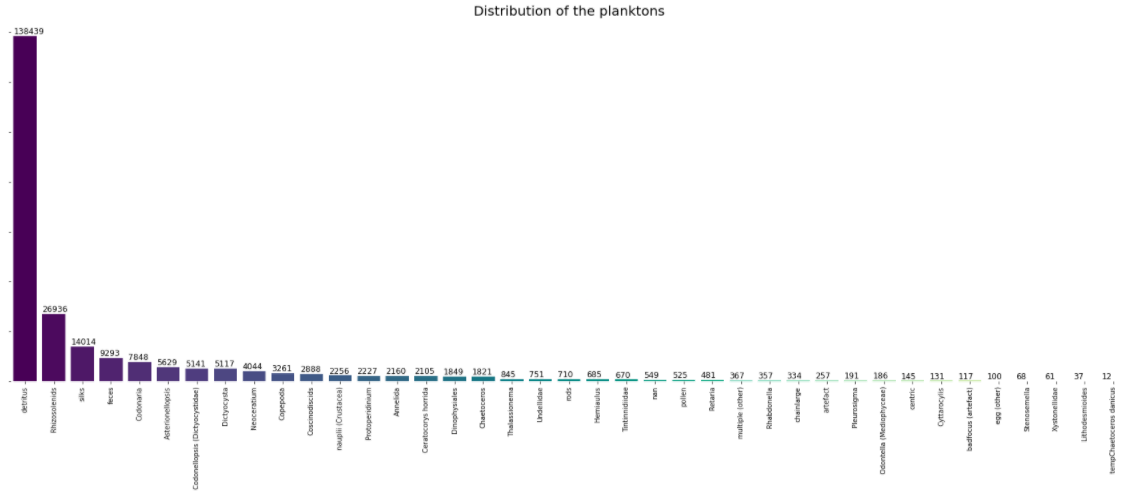

In [0]:
img_distribution = Image.open('/content/drive/My Drive/Plankton Recognition Challenge/Chloé/distribution_planktons.png')  
img_distribution

There a **39 different _level2_ categories** which we will use to classify the planktons of our dataset. 

This plot shows the distribution of the _level2_ labels within our dataset : we can clearly see that our dataset is **unbalaced** due to the high number of detritus compared to the other categories. We will need to handle this in the future because it can affect the performance of our models.

###I. a. 3) Data cleaning

In our dataset, we noticed that there were **1003 samples** which _level2_ were a NaN value so we deleted these rows because we cannot train a model on them.

Then, we handled the features containing null values. Some of the features only contained NaN values so we dropped them. For the other features, we simply replaced the NaN values by 0. Indeed, these features were area (_skeleton_area_, _symetrieh_area_ etc) for which the value 0 can be an option.

##I. b. Data preparation for the images

###I. b. 1) Data exploration

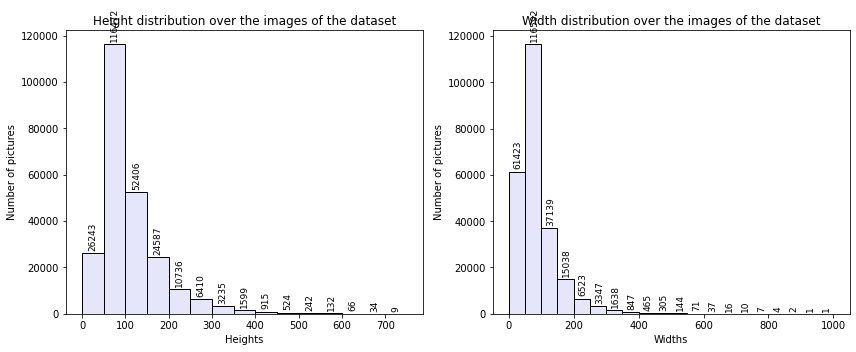

In [0]:
#img_channel = Image.open('/content/drive/My Drive/Plankton Recognition Challenge/Chloé/nb_channel.png') 
img_dimensions = Image.open('/content/drive/My Drive/Plankton Recognition Challenge/Deliverables/height-width.png')

#plt.imshow(img_channel)
img_dimensions

Thanks to an histogram, we could visualize that all the images from the dataset were only grayscale images composed of **one channel**.

Concerning the dimensions, we can see that the majority of the pictures (116 472 pictures) has a height between **50 and 100**, as well as the width (116 592 pictures). There are also some very big pictures, with heights until 739 and width until 972, that are very too big to be an input of a neural network.


The big images are not a problem, because we can reshape them without losing quality, but too small images can led to bas resulrs (bad quality after reshaping it). Thus, we must choose a **threshold** for the height and width under which images are judged **"too small"** and have to be deleted. 

As the majority of our images have dimensions between 0 and 100 we decided to set the **threshold to 32** which is not too selective and the input size for LeNet5 that we will perform later on.

###I. b. 2) Data cleaning 

In this section, we need to delete the images that are **too small** and remove the rows (images) that contain **NaN** values for the _level2_ label and create the final image dataset that will be used for the CNN models. To do so, we built a matrix called _mapping_ that associate the following features of the images : **objid**, **level2**, the **numpy matrices** representing the images and delete the bad rows. 

We noticed that **17 000 images** had to be deleted because they were too small and as said before, **1003 images** correspond to NaN_level2_ values so they were also removed.

###I. b. 3) Data augmentation

Our dataset is really unbalanced and we wanted to adress this problem and the most **straightforward and common approach** is the use of sampling methods. Those methods operate on the data itself (rather than the model) to increase its balance.

Widely used and proven to be **robust** is **oversampling**. This is the technique we are going to resort to in this section to mitigate the problem of imbalance within the _level2_ label. Indeed, while we have at least 138k of detritus images in the train set, 22 out of 39 classes are underrepresentated with less than 1k samples.

_reference_ : A systematic study of the class imbalance problem in convolutional neural networks by Mateusz Buda, Atsuto Maki, Maciej A. Mazurowski https://arxiv.org/pdf/1710.05381.pdf


Our data augmentation techniques are the following :

-  **flips** (horizontal, vertical and both)
-  **rotations** 
-  **brightness augmentation**


We were willing to keep the overall distribution of the raw and the training dataset namely a large majority of detritus, a large part of feces and the rest of the plantktons. To do so,  we **oversampled images differently** whether they belonged to a class that were either well-represented (more than 6k samples), intermediately represented (between 1k and 3,5k samples) or poorly represented (less than 1k samples). 

The samples belonging to under represented class  will go through 6 transformations (the samples will thus be multiplied by 7), the samples belonging to moderately represented will go through 2 transformations and the samples belonging to highly represented will go through 1 transformations. 

Here you can see that after the data augmentation the shape of the distribution has been preserved :

_before data augmentation_

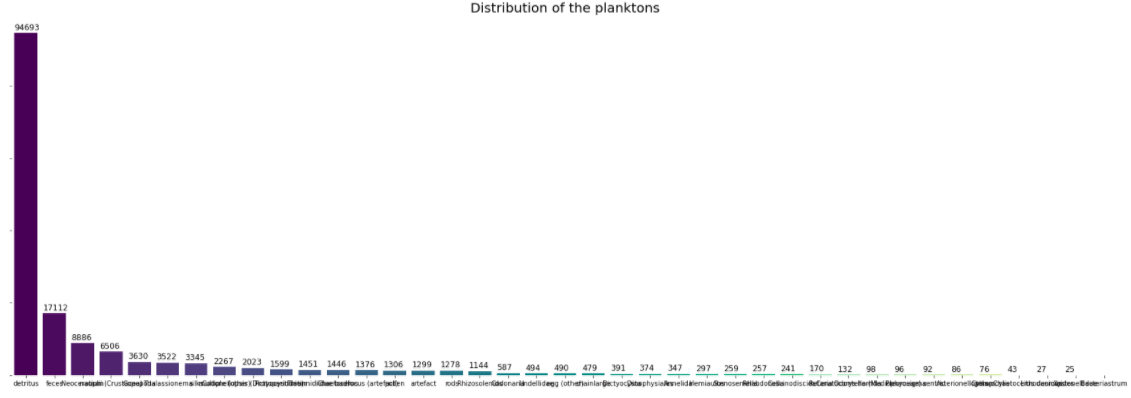

In [0]:
img_augmentation_before = Image.open('/content/drive/My Drive/Plankton Recognition Challenge/Chloé/images/distribution_before_augmentation.png')  
img_augmentation_before

_after data augmentation_

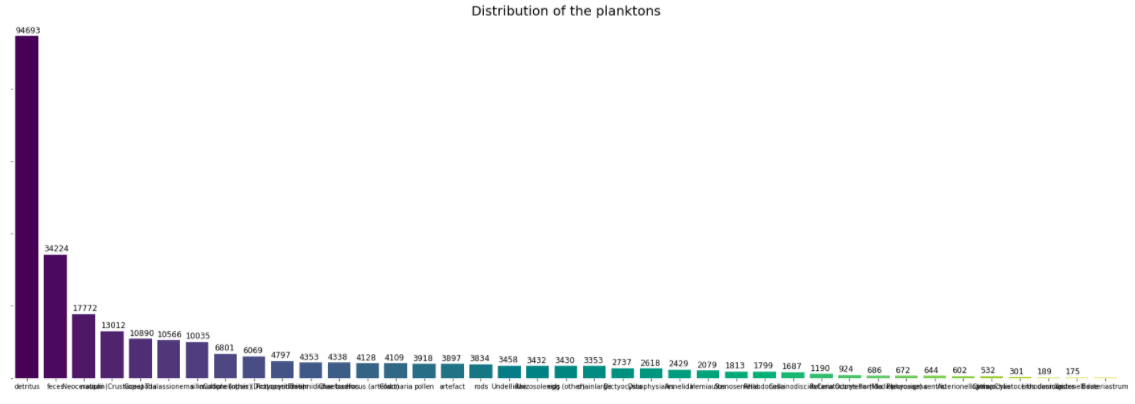

In [0]:
img_augmentation_after = Image.open('/content/drive/My Drive/Plankton Recognition Challenge/Chloé/images/distribution_after_augmentation.png')  
img_augmentation_after

#II. Model Selection


In this section we are going to test several models on our data. We will perform a **Random Forest** on the extracted features and a couple of pre-trained CNN on the images : **LeNet5** and **VGG16**. For each of these models we are going to assess their performance on training data with the **F1-score** metrics with the *average = 'macro'* option.

We made the choice to exclude **resizing** of the data preparation as each model take a different shape in input even if it will be always square images. This is why in each model section there will be a resizing step that is proper to the model.

Finally, in this section we are going to use **transfer learning** namely repurposing existing pre-trained models (LeNet5 and VGG16) for our own classification task. For each of the pre-trained model we are going to use a **different strategy** : 
- for LeNet5, we are going to train the entire model
- for VGG16, the initialization of the weights of our convolutional base are going to be ones that performs well on *imagenet* (the pre trained model)

## II. a.  Random Forest

For the Random Forest approach, we first trained the model without parameter tuning nor treatment on the dataset and with **10 trees** and then trained it on normalized data. After that, we tuned the number of trees on the **normalized** dataset : the optimal value for this parameter was **19 trees**.

Then, as we naively merged the two datasets (native and skimage), it's particularly relevant to see if there are not redundant information, so we tried a **PCA** on normalized data but unfortunately it overfit too much so we discarded this method. 

To handle the **imbalance** of the dataset, we tried 3 methods :
- oversampling with **SMOTE** but it failed due to a lack of samples in the under representated classes
- under sampling keeping only **10%** of each _level2_ labels
- undersampling selecting random samples from the dataset with  **imblearn.under_sampling.RandomUnderSampler**

_parameters tuning_

We selected the "best model" from the ones we previously trained and applied parameter tuning on it. We tuned the n_estimators parameter (number of trees) and found an optimal value of **21**.


-------------------------- **Results** --------------------------


In [0]:
pd.DataFrame([{'validation F1-score':'41.02%',},
              {'validation F1-score':'18.92%',},
              {'validation F1-score':'23.25%',},
              {'validation F1-score':'20.55%',},
              {'validation F1-score':'31.85%',},
              {'validation F1-score':'41.62%',},
              {'validation F1-score':'43%',},
              ], index=['baseline model, no parameter tuning, no dataset treatment, 10 trees', 
                    'baseline model, normalized data', 
                    'tuned model, normalized data, 19 trees',
                    'baseline model, PCA, normalized data, 10 trees', 
                    '10% undersampled dataset, 10 trees', 
                    'randomly undersampled dataset, 10 trees',
                    'randomly undersampled dataset, 21 trees'])

,validation F1-score
"baseline model, no parameter tuning, no dataset treatment, 10 trees",41.02%
"baseline model, normalized data",18.92%
"tuned model, normalized data, 19 trees",23.25%
"baseline model, PCA, normalized data, 10 trees",20.55%
"10% undersampled dataset, 10 trees",31.85%
"randomly undersampled dataset, 10 trees",41.62%
"randomly undersampled dataset, 21 trees",43%


We select the model that gave the best performance namely randomly undersampled and composed of 21 trees. [ADD COMMENTS]

-------------------------- **Final parameters for Random Forest** --------------------------

- n_estimators = 21

## II. b.  LeNet5


LeNet5 architecture takes a **32x32xC** image as input, where C is the number of color channels so **C = 1** for us since we have grayscale images. Concerning the labels representation, we resorted to one-hot encoding.

_parameters tuning_ :

We reshaped our images with  the **nearest neighbour interpolation** ((PIL.Image.NEAREST) but also with the **cubic interpolation** (PIL.Image.CUBIC) and resorted to the  **Adam optimizer** as well as the **SGD optimizer**. We also tested different **learning rates** and number of **epochs**.



-------------------------- **Results** --------------------------


In [0]:
pd.DataFrame([{'Training f1 score':'62.0%','Training accuracy':'81.8%' , 'Valid f1 score':'28.1%', 'Valid accuracy':'70.0%'},{'Training f1 score':'72.6 %','Training accuracy':'86.4 %','Valid f1 score':'27.6 %','Valid accuracy':'68.1 %'},{'Training f1 score':'54.9 %', 'Training accuracy':' 81.1  %', 'Valid f1 score':'28.9 %', 'Valid accuracy':'70.6 %'},{'Training f1 score':'49.1 %','Training accuracy':'74.3 %','Valid f1 score':'35.9 %','Valid accuracy':'46.0 %'}, {'Training f1 score':'61.8 %','Training accuracy':'77.7 %', 'Valid f1 score':'41.3 %','Valid accuracy': '51.1 %'},{'Training f1 score':'54.2 %','Training accuracy':' 74.3 %', 'Valid f1 score': '38.61  %','Valid accuracy': '45.1 %'}], index=['Nearest neighbors interpolation, lr=0.001, 42 epochs', 'Nearest neighbors interpolation, lr=0.001, 80 epochs', 'Cubic interpolation, lr=0.001, 80epochs','Augmented dataset, lr=0.001,42 epochs', 'Augmented dataset, lr=0.001, 80 epochs','lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model'])

,Training f1 score,Training accuracy,Valid f1 score,Valid accuracy
"Nearest neighbors interpolation, lr=0.001, 42 epochs",62.0%,81.8%,28.1%,70.0%
"Nearest neighbors interpolation, lr=0.001, 80 epochs",72.6 %,86.4 %,27.6 %,68.1 %
"Cubic interpolation, lr=0.001, 80epochs",54.9 %,81.1 %,28.9 %,70.6 %
"Augmented dataset, lr=0.001,42 epochs",49.1 %,74.3 %,35.9 %,46.0 %
"Augmented dataset, lr=0.001, 80 epochs",61.8 %,77.7 %,41.3 %,51.1 %
lr=0.001 with 35 epochs with the augmented dataset using f1 score as metrics to optimize the model,54.2 %,74.3 %,38.61 %,45.1 %



* We obtain the best ratio score (F1-score/number of iteration) using **f1 score** (the micro f1 score) directly to **optimize our model** ... (for the others we used accuracy to optimize the weights) : we obtain 38,6% of macro F1 score with 35 epochs... 
* We can also see that the **augmentation of the dataset** has a very good impact on the f1 score. The accuracy decreases but the f1 score increases. It's exactly what we wanted when augmenting the datet: even if we predict worse the detritus, the average accuracy is more equally distributed (we well predict globally the same number of output in all the different labels. This is confirmed by the **confusion metrix**.)
* Whether decreasing the **learning rate** to 0.01 or using **SGD** leads to divergence
* The **number of epochs** makes the f1 score increasing but we saw that doing more than 80 epochs was not relevant (the f1 score doesn't increase a lot after that).
* The **interpolation** used to resize the image doesn't impact so much the f1 score. 

-------------------------- **Final parameters for LeNet5** --------------------------


- learning rate = 0.001
- epochs = 35.

##II. c. VGG16

For RAM purposes, we selected **10% of the training samples** in each _level2_ classes to keep the same distribution as the original training set. We ended up with **15 797 samples** for the training phase.

The input of the model must be a image of size **224x224x3**, so we first reshaped our images with  the **nearest neighbour interpolation** to have an array of size (224,224). We then replicated our grey channel two times to obtain 3 identical channels.

As said in the introduction, we did tranfer learning and reused the architecture and weights of the VGG16 model trained on **ImageNet**. We just added the fully connected layer composed of **39 neurons** with the **sigmoid** activation function.

_Parameters tuning_ : 

We resorted to the  **Adam optimizer** as well as the **SGD optimizer** and also tested different **learning rates**, **momentum**, **batch size** and number of **epochs**.




-------------------------- **Results** --------------------------


In [0]:
pd.DataFrame([{'validation F1-score':'35.85%',},
              {'validation F1-score':'0.68%%',},
              {'validation F1-score':'1.93%',},
              {'validation F1-score':'10.91%',},
              {'validation F1-score':'38.38%',},
              {'validation F1-score':'39.86%',},
              {'validation F1-score':'35.65%',},
              {'validation F1-score':'43.44%',}
              ], index=['SGD, lr = 2e-3, momentum=0.9, epoch = 10, batch_size = 32', 
                    'SGD, lr = 1e-1, momentum=0.9, epoch = 10, batch_size = 32', 
                    'Adam, lr=0.01, epoch = 10, batch_size = 32',
                    'SGD, lr=1e-5, momentum = 0.9, epoch = 20, batch_size = 32', 
                    'SGD, lr=5e-3, momentum = 0.9, epoch = 20, batch_size = 32', 
                    'SGD, lr=3e-3, momentum = 0.9, epoch = 13, batch_size = 32', 
                    'SGD, lr=3e-3, momentum = 0,6, epoch = 13, batch_size = 32', 
                    'SGD, lr=2e-3, momentum = 0,9, epoch = 25, batch_size = 16'])

,validation F1-score
"SGD, lr = 2e-3, momentum=0.9, epoch = 10, batch_size = 32",35.85%
"SGD, lr = 1e-1, momentum=0.9, epoch = 10, batch_size = 32",0.68%%
"Adam, lr=0.01, epoch = 10, batch_size = 32",1.93%
"SGD, lr=1e-5, momentum = 0.9, epoch = 20, batch_size = 32",10.91%
"SGD, lr=5e-3, momentum = 0.9, epoch = 20, batch_size = 32",38.38%
"SGD, lr=3e-3, momentum = 0.9, epoch = 13, batch_size = 32",39.86%
"SGD, lr=3e-3, momentum = 0,6, epoch = 13, batch_size = 32",35.65%
"SGD, lr=2e-3, momentum = 0,9, epoch = 25, batch_size = 16",43.44%


-------------------------- **Final parameters for VGG16** --------------------------

- optimizer = SGD
- lr = 2e-3 
- momentum = 0.9
- epoch = 25
- batch_size = 16.

#III. Performance evaluation

##III. a.  Combining the results

We obtained different classification results with different algorithms. Some models are based on the features (Random Forest), others on the images (LeNet5, VGG16). Thus, merging the results can be very interesting as the results are not obtained thanks to the same data. Some mistakes done by a convolutional neural network can be done by another convolutional neural network (as they work on the same data: images), but can give another result with an algorithm using the features. 

That is why we are going to **merge the outputs** of our best algorihtms : 

- Random Forest (f1_score on the test: **41.96%**): the output gives, for each sample, a 0 vector with a unique 1, that corresponds to the predicted class.  

- LeNet5 (f1_score on the test: **37.78%**): the output gives, for each sample, the probability that this sample belongs to a given class. The predicted class is the one with the highest probability. We computed the average of the highest probability of each sample, which was 0.39.

- VGG16 (f1_score on the test: **43.44%**): same outputs as LeNet5 (vector of probabilities to belong to a class). We computed the average of the highest probability of each sample, which was 0.90.

The idea is now to sum these outputs with different weights. It will look like : 

\begin{align}
y\_pred\_merge & = \alpha * y\_pred\_rf+ \beta * y\_pred\_leNet5 + \gamma * y\_pred\_VGG16\\
\end{align}

As the predicted class is equals to 1 for the Random Forest, but less that one the LeNet5 (resp. VGG16) with an average of 0.39 (resp. 0.90), we need to give more importance to the outputs of the convolutional neural networks.  
After tuning the parameters $\alpha$, $\beta$, $\gamma$, we found that the optimal values were given by : **($\alpha$ = 1, $\beta$ = 4, $\gamma$ = 2.2)**

This model gives, on the testing set, the following results:

- **f1 score:  44.71%**
- Precision: 64.08%
- Recall: 39.90%
- Accuracy: 82.15%

As expected, it allows to improve a bit our result, by increasing the f1 score from 43.44% to 44.71%.

##III. b. Understanding the results

To see how the samples have been predicted and where the mistakes could have been done, let's plot a **normalized confusion matrix** (and not only a confusion matrix that would be meaningful for the 'detritus' class only as the data is very unbalanced). 

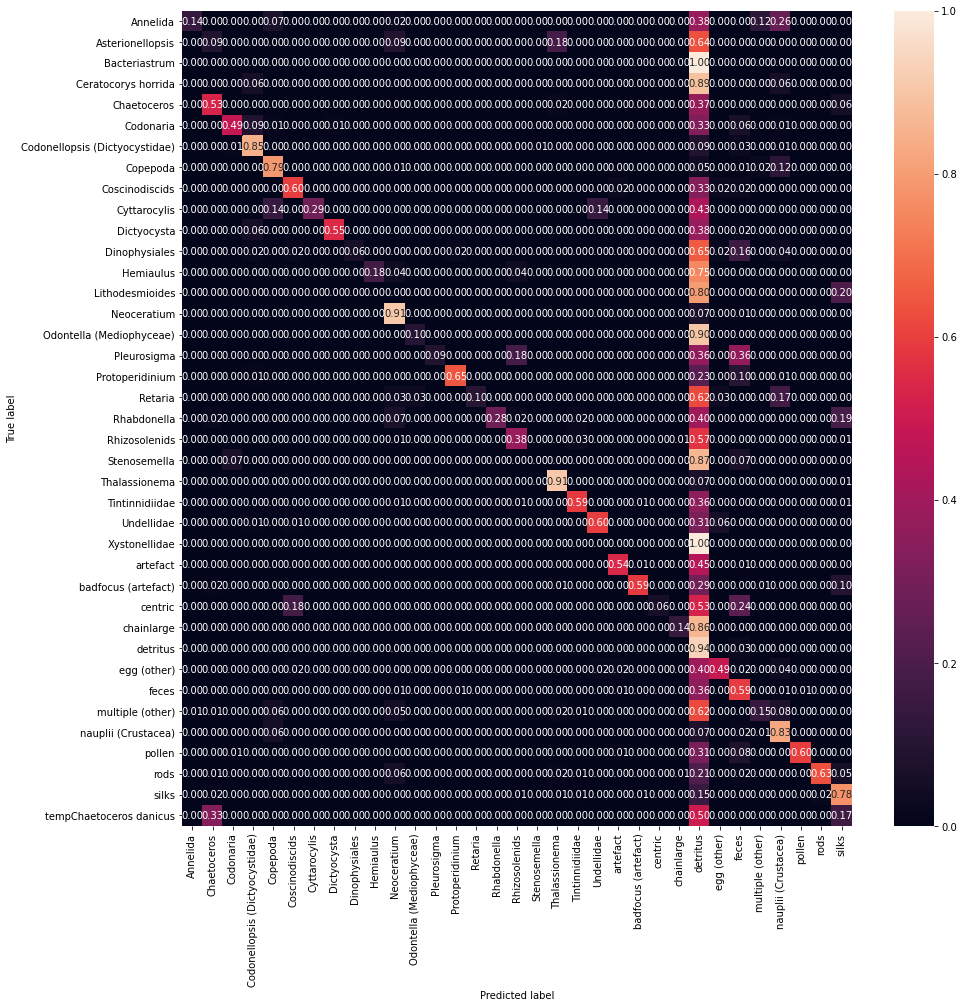

In [0]:
Image.open('/content/drive/My Drive/Plankton Recognition Challenge/Deliverables/ConfusionMatrix2.png') 

We can see thanks to this normalized confusion matrix that all classes have been globally pretty well predicted (the diagonal is visible). For example, a 'detritus' sample is well labeled 94% of time.

However, we can also see the vertical line of above the 'detritus' label, meaning that a lot of samples have been wrongly predicted with this class. For example, the 'Xystonellidae' or 'Bacteriastrum' samples have **always** been predicted as a 'detritus' (coefficient of 1.). The unbalanced distribution of our training set can explain this phenomenon: the models tend to learn too much 'detritus' planktons, and 'forgot' the other classes (especially the less represented classes such as 'Lithodesmioides').

As 'detritus' is often wrongly predicted, we can think that the true label doesn't have the highest value in $y\_pred\_merge$, but is maybe the among the 3rd or the 5th highest probability. 

Computing the top3 or top5 accuracy can thus be interesting. We found that: 

- Top1 accuracy = 82.15%
- Top3 accuracy = 96.33%
- **Top5 accuracy = 98.33%**

By looking not only at the highest values of a sample in $y\_pred\_merge$, we can see that the real label of a sample is 96.33% of the time among the 3rd highest probabilities, and 98.33% of the time among the 5th highest probabilities! Thus, it can be interesting to keep the top5 labels as it is very likely that the real label is present. It could allow to scientists that have to classify the planktons to save time for example (classify no more among 39 calsses, but 5 classes). 